コードは久保幹雄先生の[Python言語による実務で使える100+の最適化問題 乗務員スケジューリング問題](https://mikiokubo.github.io/opt100/80csp.html#%E4%B9%97%E5%8B%99%E5%93%A1%E3%82%B9%E3%82%B1%E3%82%B8%E3%83%A5%E3%83%BC%E3%83%AA%E3%83%B3%E3%82%B0%E5%95%8F%E9%A1%8C)より  
データは[こちら](http://people.brunel.ac.uk/~mastjjb/jeb/orlib/ptaskinfo.html)

In [1]:
GUROBI = True
if GUROBI:
    from gurobipy import Model, quicksum, GRB
else:
    from mypulp import Model, quicksum, GRB

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict, defaultdict
import networkx as nx

pd.set_option('display.max_rows', 200)

In [3]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

In [4]:
fname = "csp50.txt"
f = open(fname,"r")
lines = f.readlines()

n_tasks, time_limit = map(int, lines[0].split())
time_limit = 300

K = 27
# K = 7

## DataFrame化

In [5]:
time_df = pd.DataFrame()

for t in range(1,n_tasks+1):
    time_df = pd.concat([time_df, pd.DataFrame(lines[t].split(" ")).T.replace('\n', '', regex=True)])

time_df = time_df[[1, 2]].reset_index(drop=True)
time_df.columns = ["start", "finish"]
time_df = time_df.astype(int)
time_df["time"] = time_df["finish"] - time_df["start"]

# 計算量を減らすために50行から15行に変更
time_df = time_df.sample(30, random_state=SEED)

time_df.index = np.arange(1, len(time_df)+1) # indexを1からスタートに変更

# n_tasks を変更
n_tasks = len(time_df)

display(time_df.head(3))
display(time_df.tail(3))

,start,finish,time
1,342,534,192
2,1156,1190,34
3,711,765,54


,start,finish,time
28,632,691,59
29,871,951,80
30,138,325,187


In [6]:
cost_df = pd.DataFrame()

for i in range(len(time_df)):
    for j in range(len(time_df)):
        if i==j:
            continue
        else:
            if time_df.iloc[i:i+1]["finish"].values[0] < time_df.iloc[j:j+1]["start"].values[0]: # 時間が被ってない
                if time_df.iloc[j:j+1]["finish"].values[0] - time_df.iloc[i:i+1]["start"].values[0] <= time_limit: # 組み合わせたペアのトータル時間がtime_limit を超えない
                    cost_df = pd.concat([
                        cost_df,
                        pd.DataFrame([
                                i+1,# tail
                                j+1, # head
                                time_df.iloc[j:j+1]["start"].values[0] - time_df.iloc[i:i+1]["finish"].values[0], # cost
                                time_df.iloc[j:j+1]["start"].values[0] - time_df.iloc[i:i+1]["finish"].values[0]  # time
                        ]).T                                     
                    ])

cost_df.columns = ["tail", "head", "cost", "time"]
cost_df.index = np.arange(1, len(cost_df)+1)
cost_df

,tail,head,cost,time
1,1,23,20,20
2,2,4,107,107
3,2,17,26,26
4,2,18,143,143
5,2,27,88,88
6,3,9,10,10
7,3,24,121,121
8,3,25,1,1
9,3,29,106,106
10,5,7,113,113


In [7]:
D = nx.DiGraph()
for i in range(len(cost_df)):
    D.add_edge(cost_df["tail"].iloc[i], cost_df["head"].iloc[i], weight=cost_df["cost"].iloc[i],
               time=cost_df["time"].iloc[i])
for i in range(len(time_df)):
    D.add_edge(0,i+1, weight=0, time=0)
for i in range(len(time_df)):
    D.add_edge(i+1, len(time_df)+1,weight=0, 
               time=time_df["time"].iloc[i])

In [8]:
def csp_callback(model, where):
    if where !=GRB.Callback.MIPSOL:
        return
    SolGraph = nx.DiGraph()
    for (i,j) in x:
        if model.cbGetSolution(x[i,j])  >  0.1:
            SolGraph.add_edge(i,j)

    for path in nx.all_simple_paths(SolGraph, 
                                    source=0, target=n_tasks+1):
        i = path[1]
        t_sum = time_df["finish"].iloc[i-1] - time_df["start"].iloc[i-1]
        for j in  path[2:-1]:
            t_sum += time_df["finish"].iloc[j-1] - time_df["start"].iloc[j-1]
            t_sum += max(time_df["start"].iloc[j-1] - time_df["finish"].iloc[j-1], 0)
            i = j
        if t_sum > time_limit:
            edges =[]
            i = path[0]
            for j in path[1:]: 
                edges.append( (i,j) )
                i = j
            model.cbLazy(  quicksum( x[i,j] 
           for (i,j) in edges) <=len(edges) -1)   
    return

In [9]:
model = Model()
x = {}
for (i,j) in D.edges():
    x[i,j] = model.addVar(vtype="B",name=f"x[{i},{j}]")
model.update()
for i in range(1,n_tasks+1):
    model.addConstr( quicksum( x[i,j] for j in D.successors(i) ) 
                    == 1, name=f"task_execution[{i}]" )
for i in range(1,n_tasks+1):
    model.addConstr( quicksum( x[j,i] for j in D.predecessors(i) )
                    == quicksum( x[i,j] for j in D.successors(i) ),
                    name=f"flow_conservation[{i}]" )   
model.addConstr(quicksum( x[0,j]  for j in D.successors(0) )==K)
model.setObjective( quicksum(D[i][j]["weight"]*x[i,j] 
                 for (i,j) in x), GRB.MINIMIZE) 
if GUROBI:
    model.Params.DualReductions = 0
    model.params.LazyConstraints = 1
    model.optimize(csp_callback)

Restricted license - for non-production use only - expires 2022-01-13
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61 rows, 114 columns and 282 nonzeros
Model fingerprint: 0x778183b4
Variable types: 0 continuous, 114 integer (114 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 336.0000000
Presolve removed 31 rows and 31 columns
Presolve time: 0.00s
Presolved: 30 rows, 83 columns, 145 nonzeros
Variable types: 0 continuous, 83 integer (83 binary)

Root relaxation: objective 5.000000e+00, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Obj

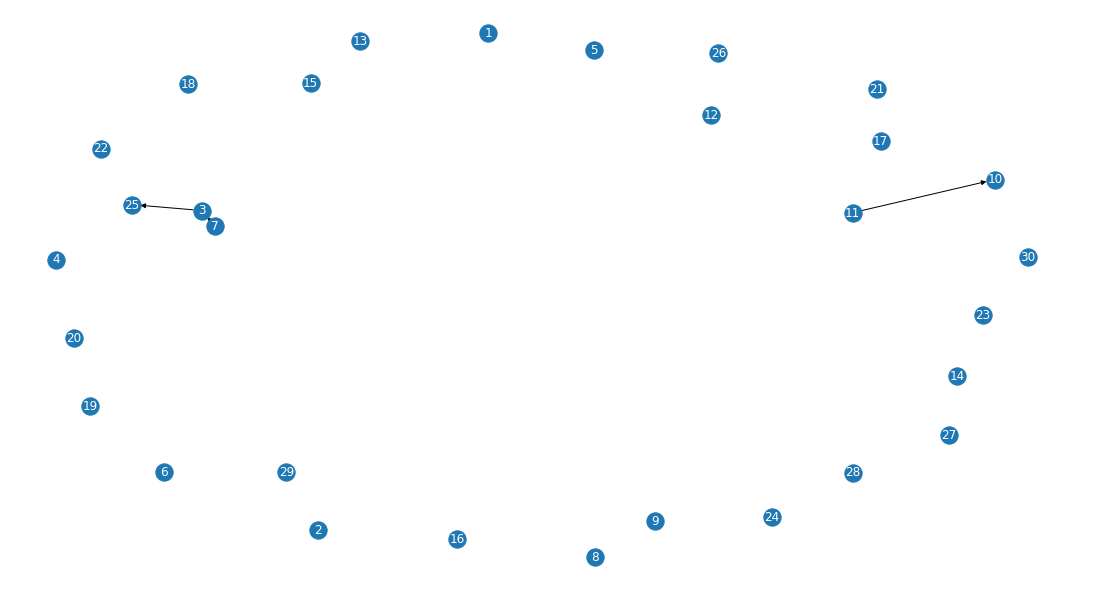

In [10]:
plt.figure(figsize=(15, 8))
alpha = 0.1

SolGraph = nx.DiGraph()
for (i,j) in x:
    if x[i,j].X > 0.1:
        SolGraph.add_edge(i,j)
SolGraph.remove_node(0)
SolGraph.remove_node(n_tasks+1)

pos = nx.spring_layout(SolGraph)

nx.draw(SolGraph, pos=pos)
nx.draw_networkx_labels(SolGraph, pos=pos, font_color='w');

## パス型定式化

In [11]:
def k_th_sp(G, source, sink, k, weight="weight", time_limit=time_limit):
    """
    Find k-th shortest paths and returns path and its cost
    """
    time_list, path_list = [], [] 
    for i, p in enumerate(nx.shortest_simple_paths(G,
           source, sink, weight=weight)):
        if i >= k:
            break
        v = p[0]
        time = 0.
        for w in p[1:]:
            time += G[v][w][weight]
            v = w
        if time>time_limit:
            break
        time_list.append( time )
        path_list.append( tuple(p)) 
    return time_list, path_list

In [12]:
time_list, path_list = k_th_sp(D,0,n_tasks+1,100000,weight="time")

C = {}
Paths = defaultdict(set)
for p, path in enumerate(path_list):
    cost_ = 0
    for j in range(1,len(path)-1):
        cost_ += D[path[j]][path[j+1]]["weight"]
        Paths[path[j]].add(p)
    C[p] = cost_

In [13]:
model = Model()
X = {}
for p in C:
    X[p] = model.addVar(vtype="B",name=f"x({p})")
model.update()  
for t in range(1,n_tasks+1):
    model.addConstr( quicksum(X[p] for p in Paths[t]) >=1 )
model.addConstr( quicksum( X[p] for p in X) ==K)
model.setObjective( quicksum(C[p]*X[p] for p in X), 
                   GRB.MINIMIZE) 

model.optimize()

print(model.ObjVal)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 31 rows, 562 columns and 2937 nonzeros
Model fingerprint: 0x572ee68e
Variable types: 0 continuous, 562 integer (562 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 2746.0000000
Presolve removed 2 rows and 2 columns
Presolve time: 0.01s
Presolved: 29 rows, 560 columns, 2933 nonzeros
Variable types: 0 continuous, 560 integer (560 binary)

Root relaxation: objective 5.000000e+00, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.0000000    5.00000  0.00%     -    0s

Explored 0 nodes (40 simplex iterations) in 0.04 second

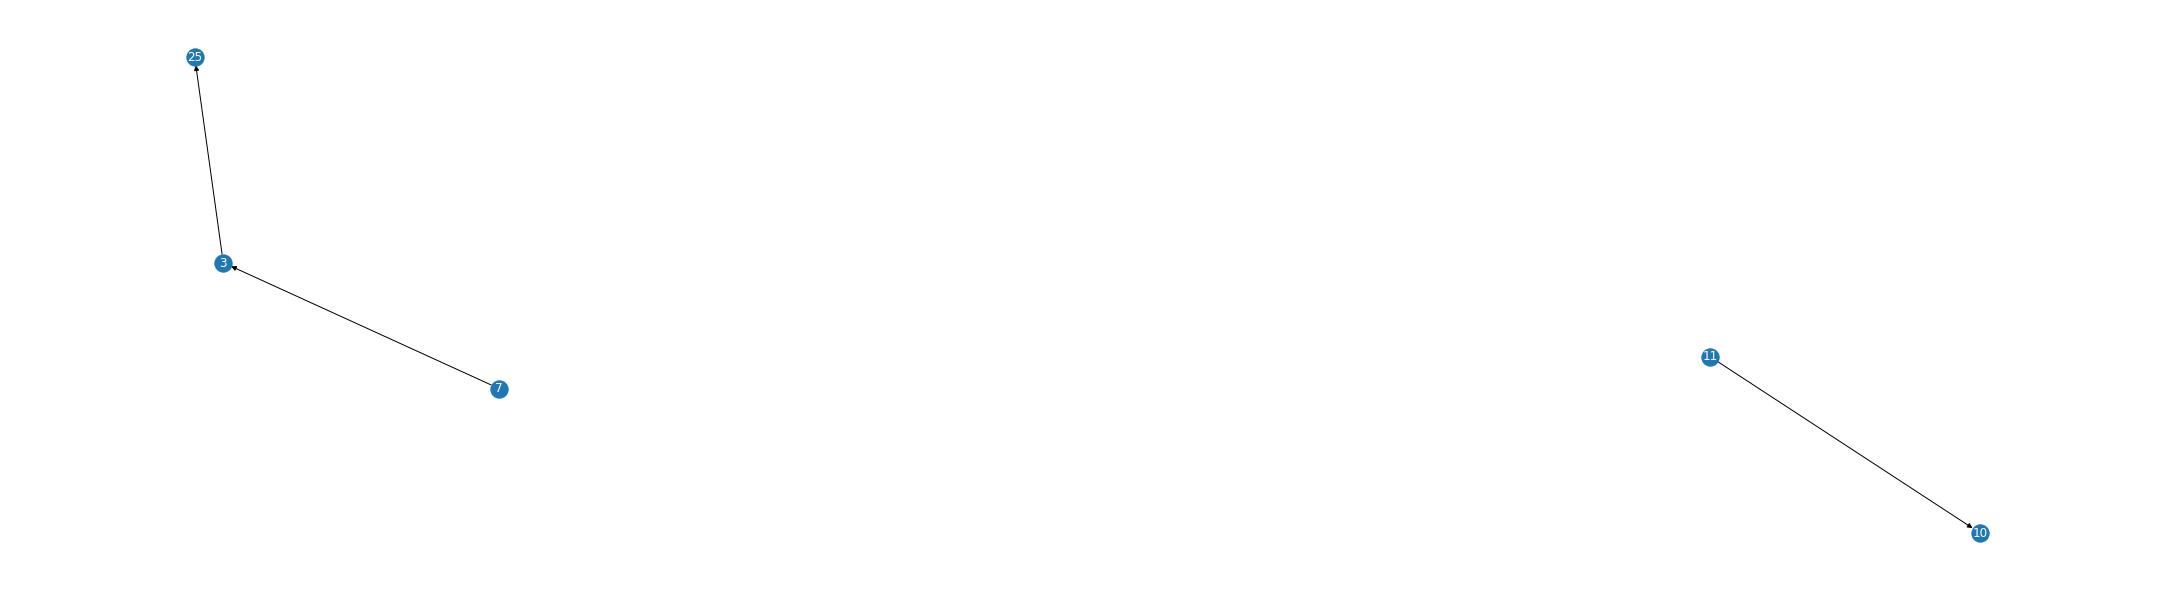

In [17]:
plt.figure(figsize=(15, 8))
pair_list = []

SolGraph = nx.DiGraph()
for p in X:
    if X[p].X >0.01:
        pair_list.append(list(path_list[p][1:-1]))
        for j in range(1,len(path_list[p])-2):
            SolGraph.add_edge( path_list[p][j], path_list[p][j+1] )

pos = nx.spring_layout(SolGraph)
nx.draw(SolGraph, pos=pos)
nx.draw_networkx_labels(SolGraph, pos=pos, font_color='w');

In [18]:
pos

{7: array([-0.39896883, -0.12691325]),
 3: array([-0.6595556 ,  0.10435147]),
 25: array([-0.68660168,  0.48264077]),
 11: array([ 0.74512611, -0.068157  ]),
 10: array([ 1.        , -0.39192199])}

### 組み合わせ

In [20]:
pair_df = pd.DataFrame()

for i in range(len(pair_list)):
    pair = pair_list[i]

    tmp_df = time_df.iloc[np.array(pair)-1]
    tmp_df["group"]=i
    pair_df = pd.concat([pair_df, tmp_df])

pair_df = pair_df[["group", "start", "finish", "time"]]
pair_df = pair_df.reset_index(drop=True)

pair_df.head()

<ipython-input-20-9cb4287a88cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["group"]=i


,group,start,finish,time
0,0,97,118,21
1,1,1333,1362,29
2,2,576,708,132
3,2,711,765,54
4,2,766,791,25
